# <center>Garch model for volatility prediction</center>

## Goal
Given the data of the record for daily volatility of the future rb. We want to predict the 5 days ahead volatility. 

## Assumption
The assumption is that volatility satisfies the normal distribution centered at 0. We will use the EWMA model to evaluate the next few days' volatility. We want find the parameter $\alpha$ for Garch model to minimize the maximum likelihood estimators.

In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
df = pd.read_csv('1.csv')
df = df[['datetime','rb']]
df = df.dropna(axis=0, how='any')
df = df.reset_index(drop=True)
df = df['rb'].values



In [3]:
import numpy as np 
import numba

@numba.guvectorize([(numba.float64[:], numba.float64,numba.float64,numba.float64, numba.float64[:])],'(n),(),(),()->(n)', nopython=True)     
def variance(returns, w, alpha, beta, results):
    tempo = 1e-4
    for i in range(0, len(returns)):
        tempo = w + beta*tempo + alpha*returns[i]**2
        results[i] = tempo



In [4]:
# When compute log likelihood, dropout some samples in the begining.

def log_like(step_ahead, returns, w, alpha, beta, dropout):
    v = variance(returns, w, alpha, beta);
    v = v[:len(v) - step_ahead];
    returns_shift = returns[step_ahead:];
    b = (- np.log(v) - (returns_shift ** 2)/ v);
    return sum(b[dropout:]) / 2;



In [5]:
@numba.guvectorize([(numba.float64[:], numba.float64, numba.float64[:])],'(n),()->(n)',nopython=True)
def deri_v_alpha(returns, beta, deri_v):
    deri_v[0] = returns[0]**2
    tempo = deri_v[0]
    for k in range(1, len(returns)):
        tempo = returns[k]**2 + beta*tempo;
        deri_v[k] = tempo;




In [6]:
@numba.guvectorize([(numba.float64[:], numba.float64, numba.float64[:], numba.float64[:])],'(n),(),(n)->(n)',nopython=True)
def deri_v_beta(returns, beta, v, deri_v):
    deri_v[0] = 1e-4
    tempo = deri_v[0]
    for k in range(1, len(returns)):
        tempo = v[k-1] + beta*tempo;
        deri_v[k] = tempo;



In [7]:
@numba.guvectorize([(numba.float64[:], numba.float64, numba.float64[:])],'(n),()->(n)',nopython=True)
def deri_v_w(returns, beta, deri_v):
    tempo = 1;
    deri_v[0] = 1;
    for k in range(1, len(returns)):
        tempo = 1 + beta*tempo;
        deri_v[k] = tempo;




In [8]:
def deri_log_alpha(returns, w, alpha, beta, dropout):
    v = variance(returns, w, alpha, beta);
    deri = deri_v_alpha(returns, beta);
    v = v[:len(v)-5];
    deri = deri[:len(deri)-5];
    returns = returns[5:];
    a = (-1/v + (returns**2)/(v**2))*deri;
    return sum(a[dropout:])/2;

In [9]:
def deri_log_beta(returns, w, alpha, beta, dropout):
    v = variance(returns, w, alpha, beta);
    deri = deri_v_beta(returns, beta, v);
    v = v[:len(v)-5];
    deri = deri[:len(deri)-5];
    returns = returns[5:];
    a = (-1/v + (returns**2)/(v**2))*deri;
    return sum(a[dropout:])/2;

In [10]:
def deri_log_w(returns, w, alpha, beta, dropout):
    v = variance(returns, w, alpha, beta)
    deri = deri_v_w(returns, beta)
    v = v[:len(v)-5]
    deri = deri[:len(deri)-5]
    returns = returns[5:]
    a = (-1/v + returns**2/(v**2))*deri
    return sum(a[dropout:])/2

In [11]:
import numpy as np 
import scipy.optimize as optimize
def optimal_parameter(returns, step_ahead, x_0, x_1, x_2, dropout): 
    fun = lambda x: -log_like(step_ahead, returns, x[0], x[1], x[2], dropout) 
    jacobian = lambda x: ([-deri_log_w(returns, x[0], x[1], x[2], dropout), 
                           -deri_log_alpha(returns, x[0], x[1], x[2], dropout), 
                           -deri_log_beta(returns, x[0], x[1], x[2], dropout)]) 
    bnds = [(0.000001,0.00001), (0.01,0.2), (0.75,0.999)] 
    cons = ({'type': 'ineq', 'fun': lambda x: 1 - x[1] - x[2]}) 
    res = optimize.minimize(fun, [(x_0, x_1, x_2)], bounds=bnds, jac=jacobian, constraints=cons, method='SLSQP') 
    result = res.x 
    return result

In [12]:
def expand_alpha_garch(returns, step_ahead, window_length, x_initial, dropout):
    l = window_length
    initial = returns[:l+step_ahead]
    x = optimal_parameter(initial, step_ahead, x_initial[0], x_initial[1], x_initial[2],dropout)
    expand_alpha_garch = []
    for j in range(0, l):
        expand_alpha_garch.append(x)
    for i in range(1, len(returns)-step_ahead-l+1):
        window = returns[: i+l+step_ahead]
        x = optimal_parameter(window, step_ahead, x[0], x[1], x[2], dropout)
        expand_alpha_garch.append(x)
    return expand_alpha_garch



In [13]:
# x_initial is the initial value for w, alpha, beta

def expand_v_garch(returns, step_ahead, window_length, x_initial, dropout):
    l = window_length
    initial = returns[:l+step_ahead]
    x = optimal_parameter(initial, step_ahead, x_initial[0], x_initial[1], x_initial[2], dropout)
    expand_v = variance(initial[:l], x[0], x[1], x[2])
    for i in range(1, len(returns)-step_ahead-l+1):
        window = returns[: i+l+step_ahead]
        x = optimal_parameter(window, step_ahead, expand_v[0], expand_v[1], expand_v[2], dropout)
        tempo = variance(returns[:i+l], x[0], x[1], x[2])[-1]
        expand_v = np.append(expand_v,tempo)
        
    return expand_v



In [14]:
def expand_performance_garch(returns, step_ahead, window_length, x_initial, dropout):
    estimate_v = expand_v_garch(returns, step_ahead, window_length, x_initial, dropout)
    returns_shift =  returns[step_ahead:]
    b = (- np.log(estimate_v) - (returns_shift ** 2)/estimate_v)
    return sum(b[window_length+100:])/(2*(len(b)-window_length-100))
        



In [15]:
def rolling_alpha_garch(returns, step_ahead, window_length, x_initial, dropout):
    l = window_length
    initial = returns[:l+step_ahead]
    x = optimal_parameter(initial, step_ahead, x_initial[0], x_initial[1], x_initial[2], dropout)
    rolling_alpha_garch = []
    for j in range(0, l):
        rolling_alpha_garch.append(x)
    for i in range(1, len(returns)-step_ahead-l+1):
        window = returns[i: i+l+step_ahead]
        x = optimal_parameter(window, step_ahead, x[0], x[1], x[2], dropout)
        rolling_alpha_garch.append(x)
    return rolling_alpha_garch




In [16]:
def rolling_v_garch(returns, step_ahead, rolling_window_length, x_initial, dropout):
    l = rolling_window_length
    initial = returns[:l+step_ahead]
    x = optimal_parameter(initial, step_ahead, x_initial[0], x_initial[1], x_initial[2], dropout)
    rolling_v = variance(initial[:l], x[0], x[1], x[2])
    for i in range(1, len(returns)-step_ahead-l+1):
        rolling_window = returns[i: i+l+step_ahead]
        x = optimal_parameter(rolling_window, step_ahead, x_initial[0], x_initial[1], x_initial[2], dropout)
        tempo = variance(rolling_window[:l], x[0], x[1], x[2])[-1]
        rolling_v = np.append(rolling_v, tempo)
    return rolling_v



In [17]:
def rolling_performance_garch(returns, step_ahead, window_length, x_initial, dropout):
    estimate_v = rolling_v_garch(returns, step_ahead, window_length, x_initial, dropout)
    returns_shift =  returns[step_ahead:]
    b = (- np.log(estimate_v) - (returns_shift ** 2)/estimate_v)
    return sum(b[window_length+100:])/(2*(len(b)-window_length-100))
        



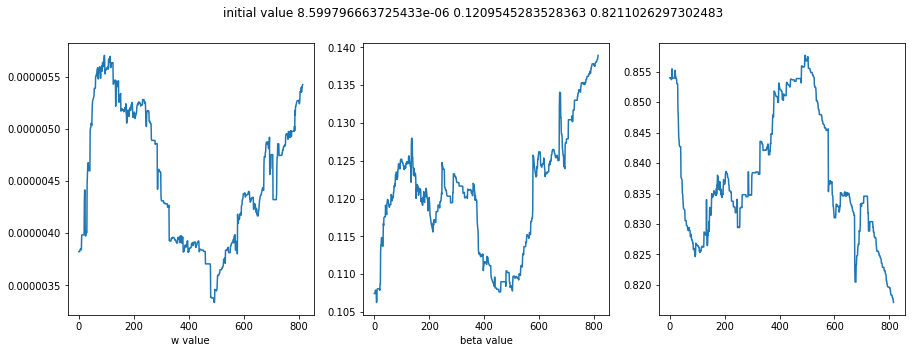

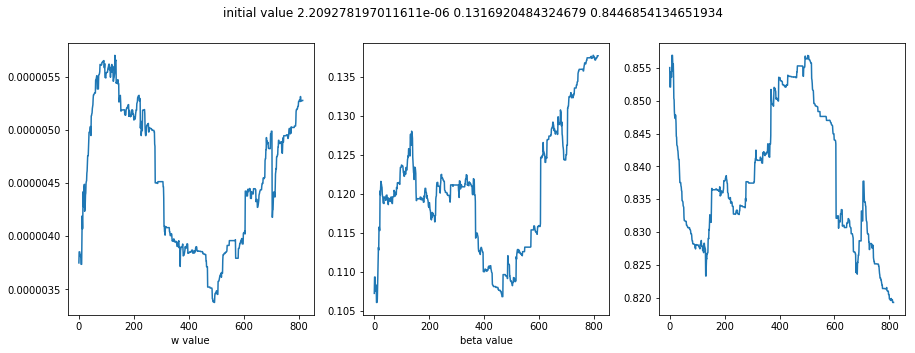

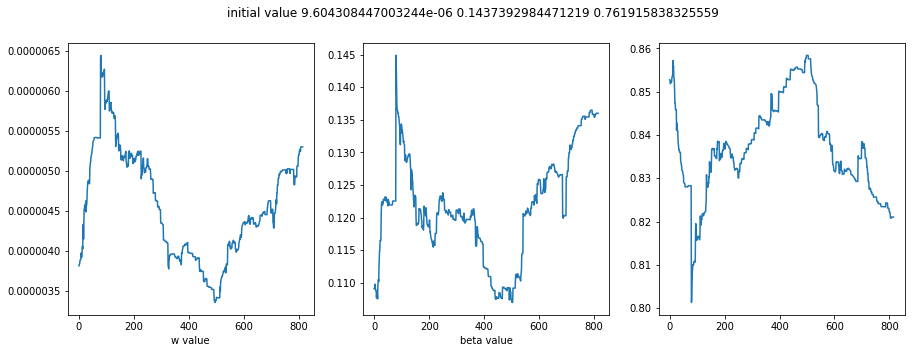

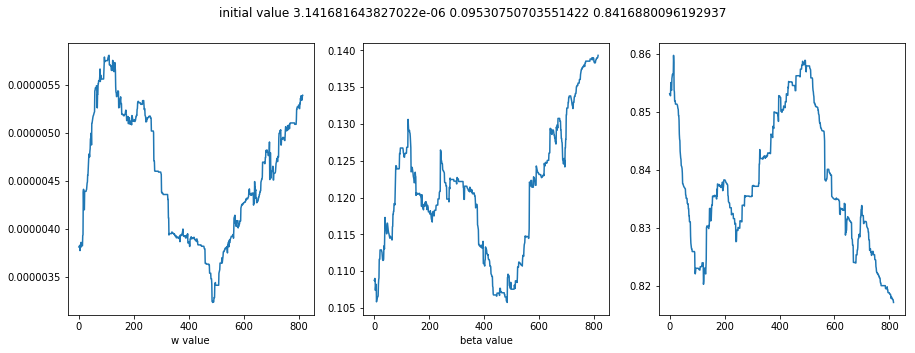

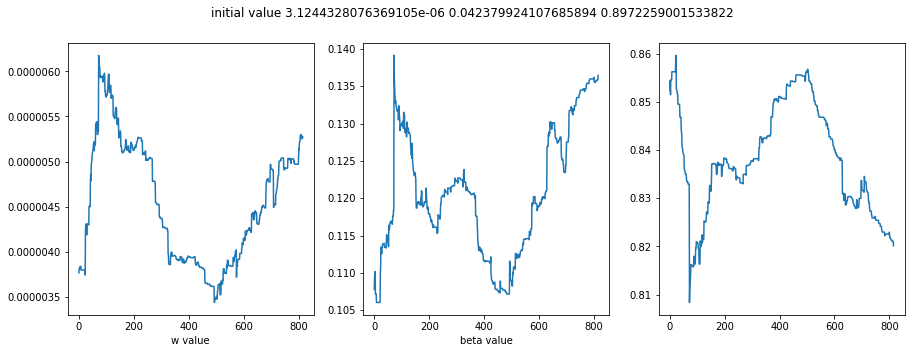

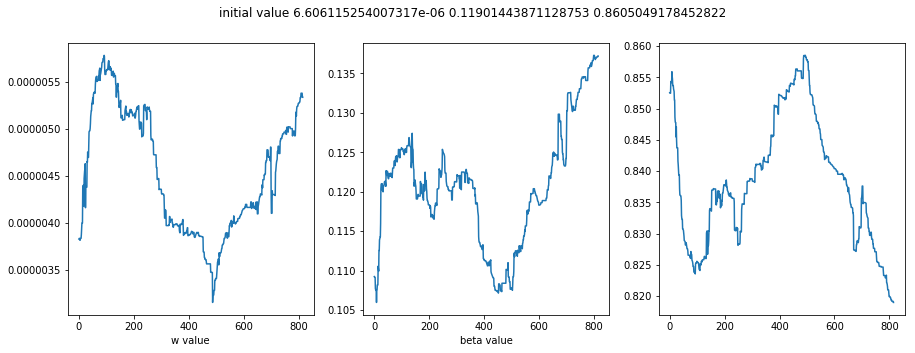

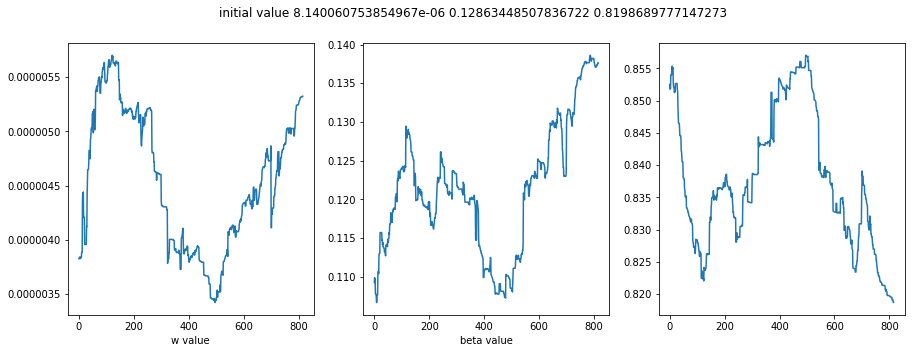

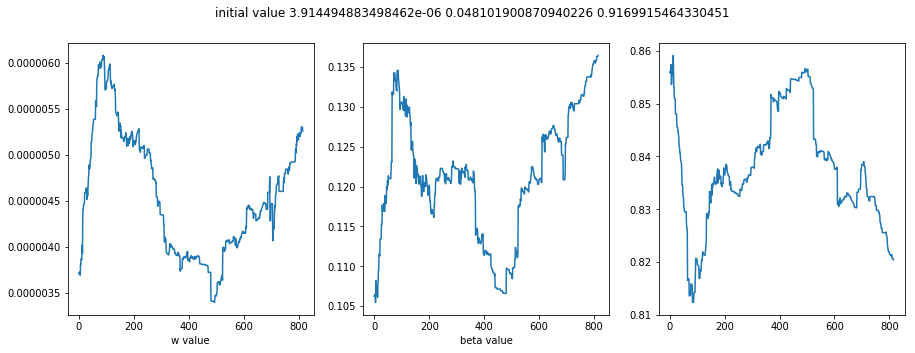

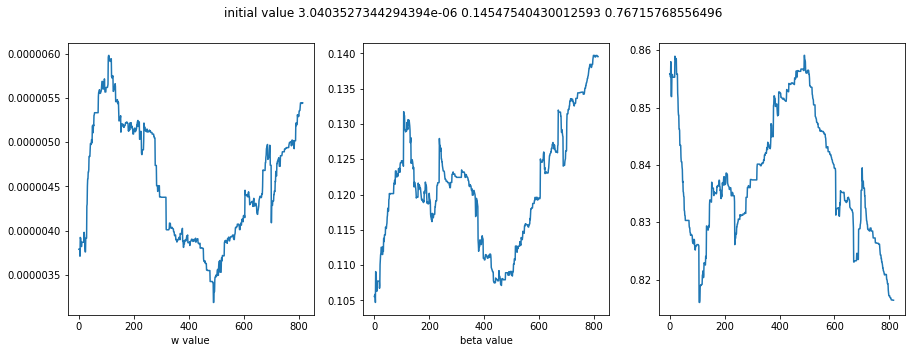

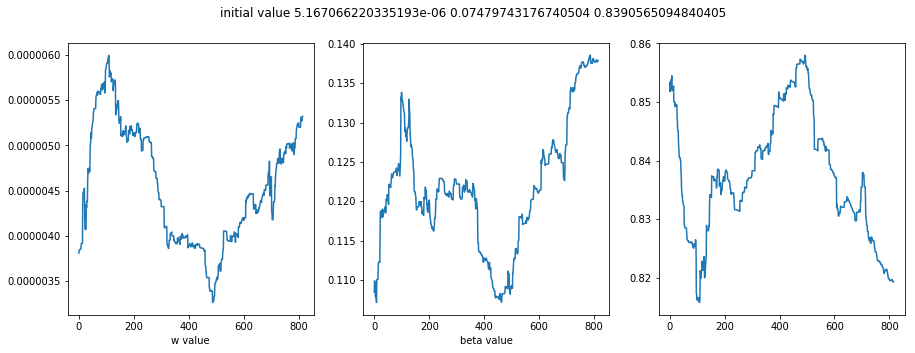

In [167]:
# As an example, take expanding window length to be 720, choose initial value randomly, drop the window and the
# first 100 samples, then plot expanding alpha.


for i in range(10):
    random.seed(i)
    w_0, alpha_0 = random.uniform(0.000001,0.00001), random.uniform(0.03,0.15)
    beta_0 = random.uniform(0.9-alpha_0,1-alpha_0)
    b = expand_alpha_garch(df, 5, 720, [w_0, alpha_0, beta_0], 100)[720+100:]
    w_value = []
    alpha_value = []
    beta_value = []
    for x in b:
        w_value.append(x[0])
        alpha_value.append(x[1])
        beta_value.append(x[2])
    f = plt.figure(figsize=(15,5))
    f.suptitle('initial value '+str(w_0)+' '+str(alpha_0)+' '+str(beta_0))
    ax = f.add_subplot(131)
    ax.set_xlabel('w value')
    ax.plot(w_value)
    ax1 = f.add_subplot(132)
    ax1.set_xlabel('alpha value')    
    ax1.plot(alpha_value)
    ax2 = f.add_subplot(133)
    ax1.set_xlabel('beta value')    
    ax2.plot(beta_value)
    plt.show()
    plt.close()
    
# we see from the picture that if the window length is 720, the expanding alpha does not significantly depend on 
# initial value.

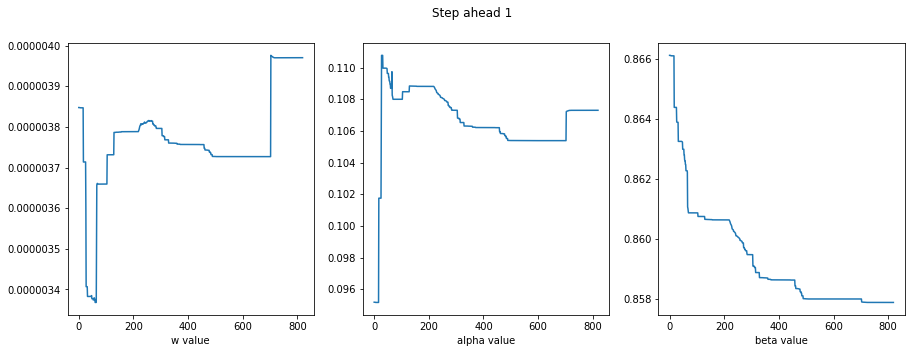

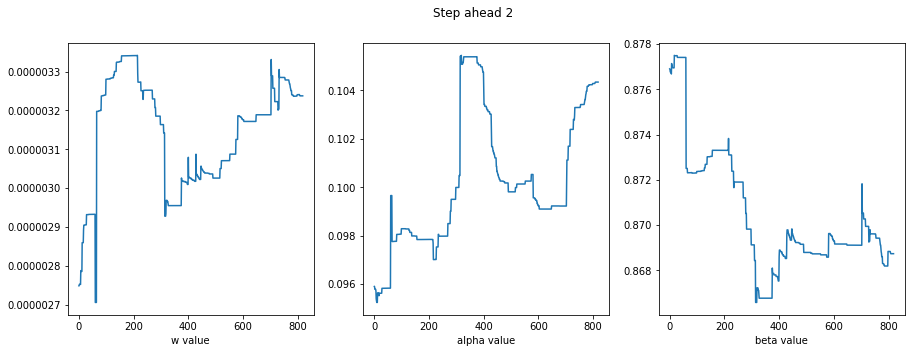

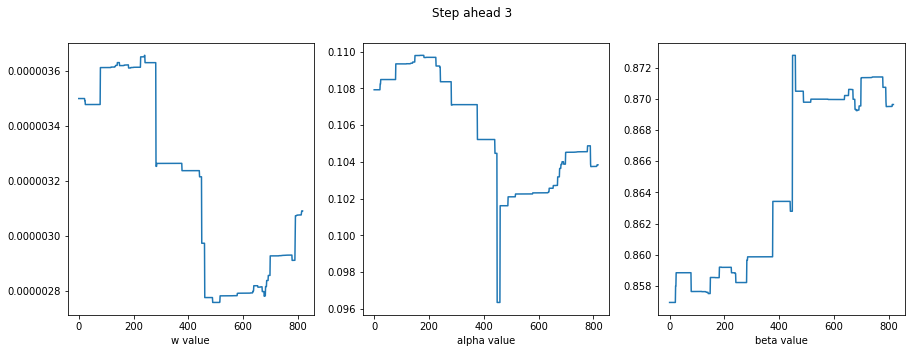

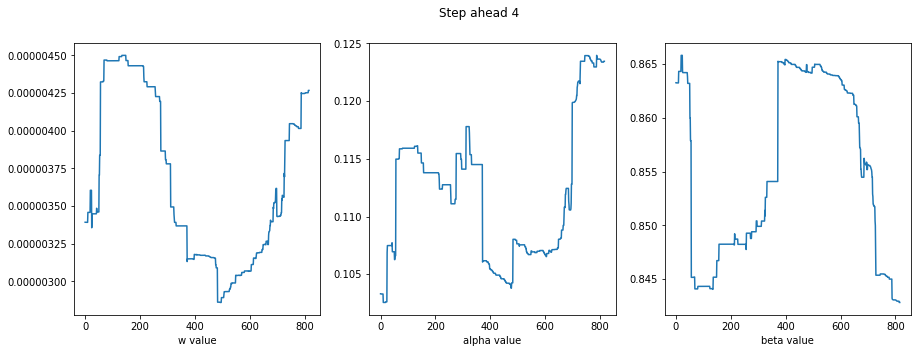

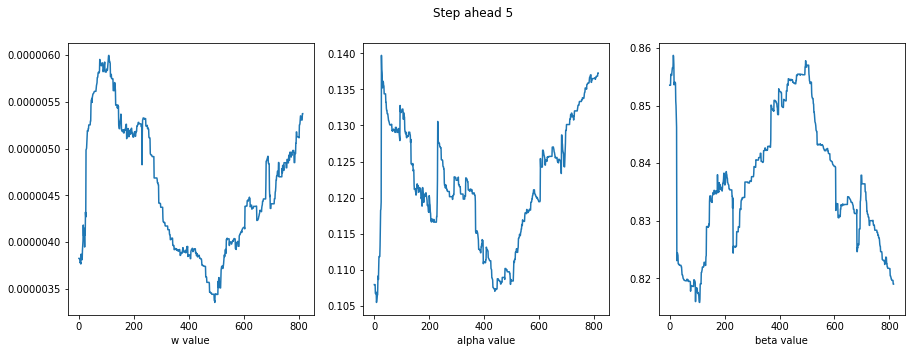

In [168]:
# As an example, take expanding window length to be 720, choose an initial value, drop the window and the
# first 100 samples, compare the plots for different step ahead.

random.seed(10)
w_0, alpha_0 = random.uniform(0.000001,0.00001), random.uniform(0.03,0.15)
beta_0 = random.uniform(0.9-alpha_0,1-alpha_0)
performance = []
x_initial = [w_0, alpha_0, beta_0]

for i in range(1,6):
    b = expand_alpha_garch(df, i, 720, [w_0, alpha_0, beta_0], 100)[720+100:]
    w_value = []
    alpha_value = []
    beta_value = []
    for x in b:
        w_value.append(x[0])
        alpha_value.append(x[1])
        beta_value.append(x[2])
    f = plt.figure(figsize=(15,5))
    f.suptitle('Step ahead '+str(i))
    ax = f.add_subplot(131)
    ax.set_xlabel('w value')
    ax.plot(w_value)
    ax1 = f.add_subplot(132)
    ax1.set_xlabel('alpha value')
    ax1.plot(alpha_value)
    ax2 = f.add_subplot(133)
    ax2.set_xlabel('beta value')
    ax2.plot(beta_value)
    plt.show()
    plt.close()
    

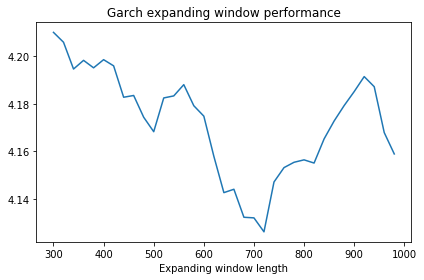

In [166]:
# Choose some initial value and plot the expanding performance for different window size
import matplotlib.pyplot as plt
import random

random.seed(1)
w_0, alpha_0 = random.uniform(0.000001,0.00001), random.uniform(0.03,0.15)
beta_0 = random.uniform(0.9-alpha_0,1-alpha_0)
performance = []
x_initial = [w_0, alpha_0, beta_0]
linespace = np.arange(300, 1000, 20, dtype=int)

for i in linespace:
    b = expand_performance_garch(df, 5, i, x_initial, 100)
    performance.append(b)
    
plt.plot(linespace, performance)
plt.xlabel('Expanding window length')
plt.title('Garch expanding window performance')
plt.tight_layout()
plt.show()
plt.close()

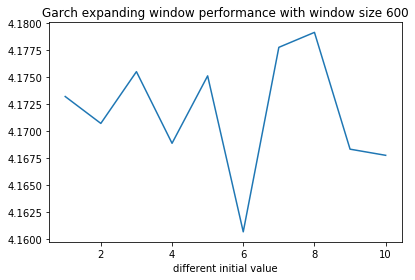

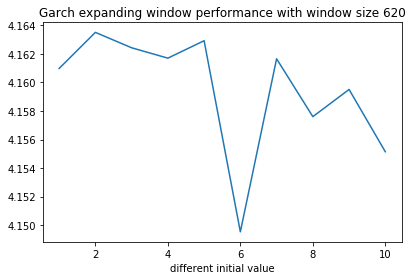

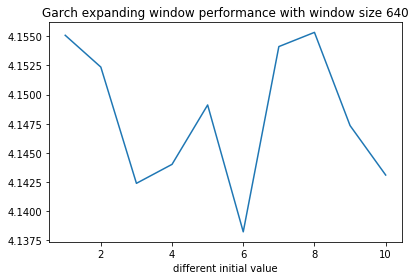

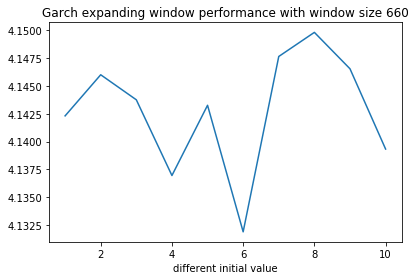

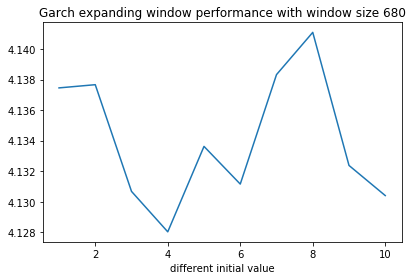

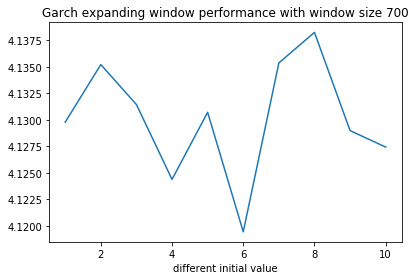

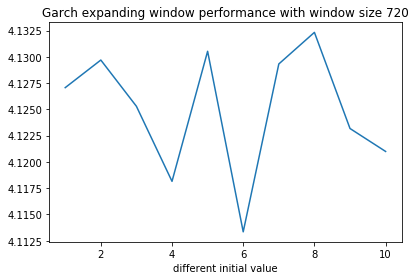

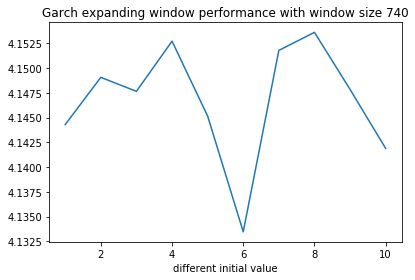

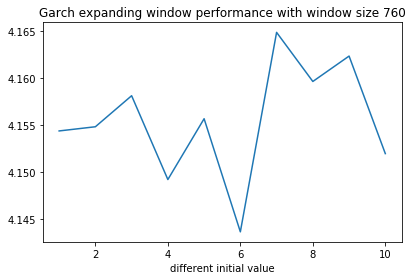

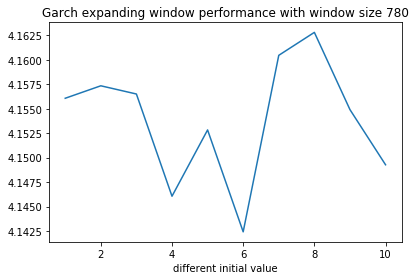

In [170]:
# Choose different initial value and plot the expanding performance for window size between 600 and 800.

import matplotlib.pyplot as plt
import random

initial_value = []
array = np.arange(1, 11)
for i in array:
    random.seed(i+600)
    w_0, alpha_0 = random.uniform(0.000001,0.00001), random.uniform(0.03,0.15)
    beta_0 = random.uniform(0.9-alpha_0,1-alpha_0)
    initial_value.append([w_0, alpha_0, beta_0])
    
windows = np.arange(600, 800, 20, dtype=int)
for k in windows:
    performance = []
    for i in range(10):
        b = expand_performance_garch(df, 5, k, initial_value[i], 100)
        performance.append(b)
    plt.plot(array, performance)
    plt.xlabel('different initial value')
    plt.title('Garch expanding window performance with window size '+str(k))
    plt.tight_layout()
    plt.show()
#plt.close()



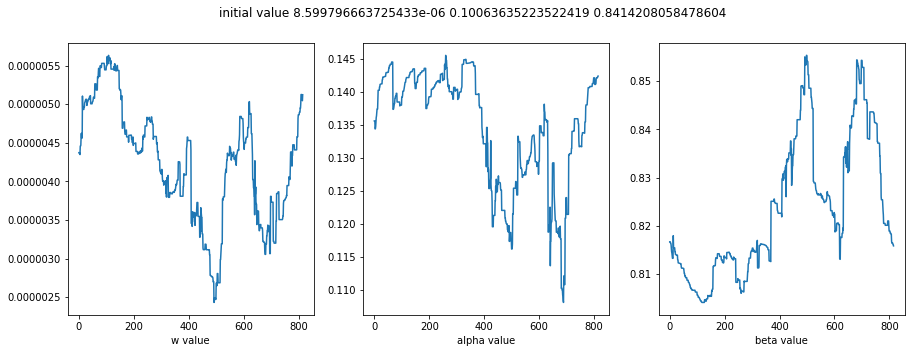

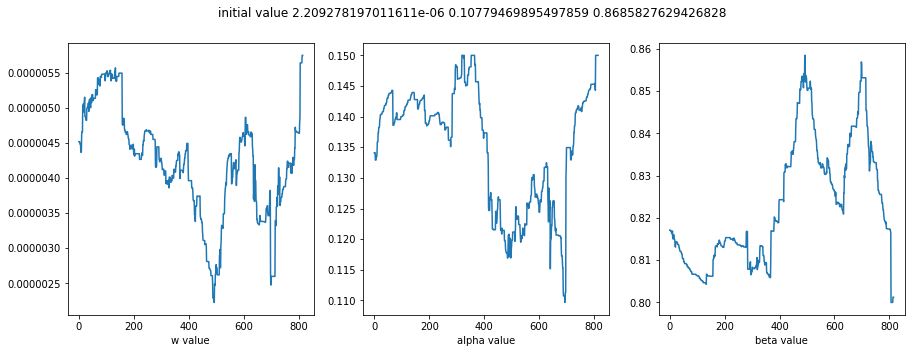

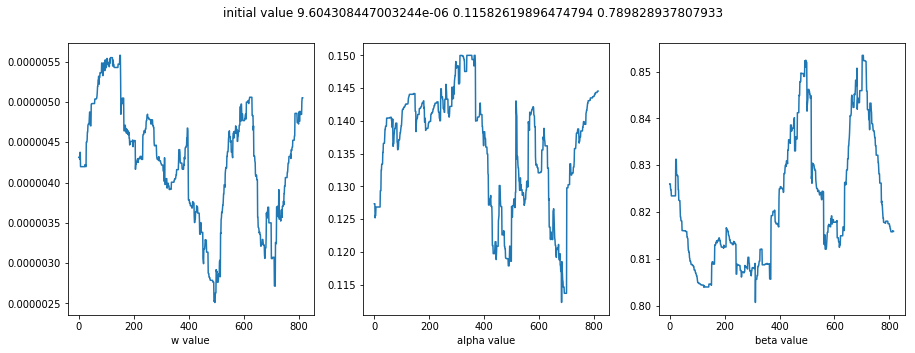

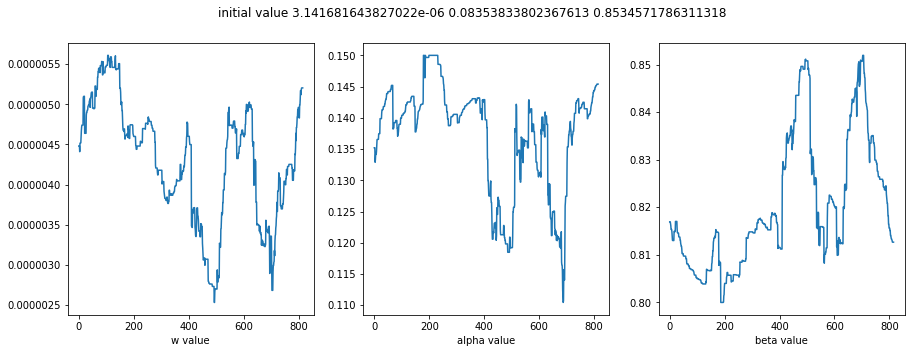

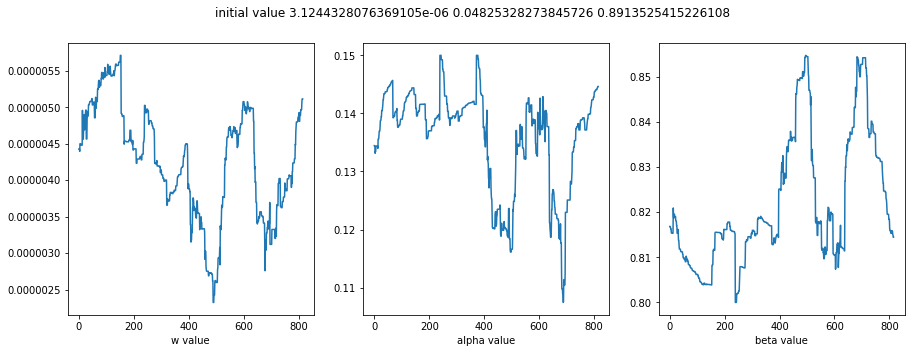

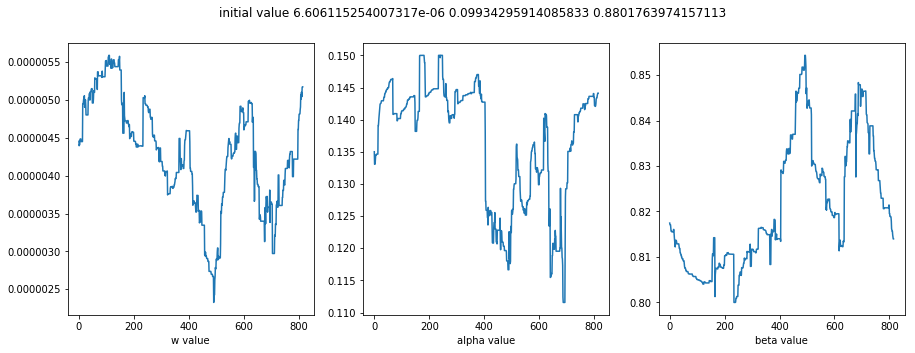

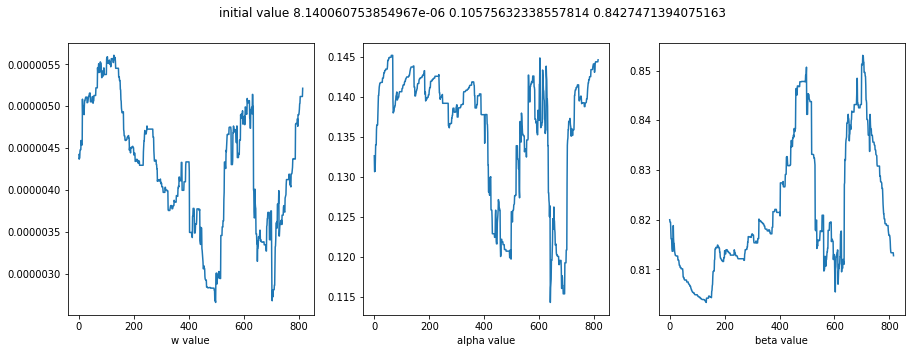

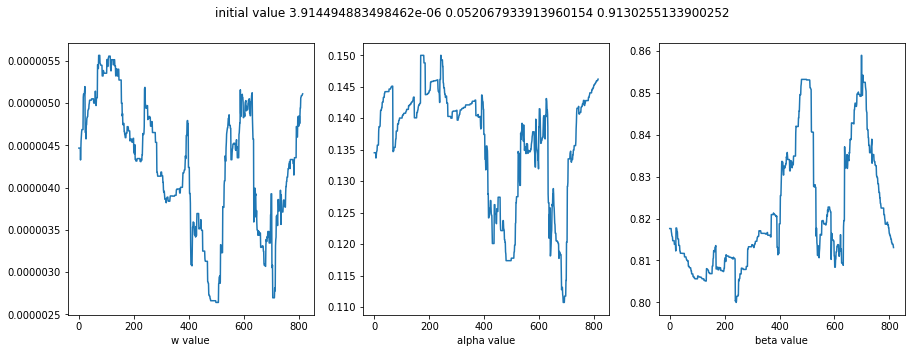

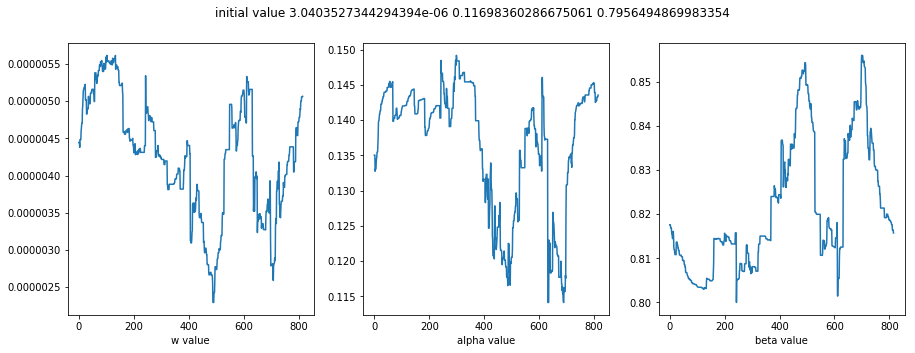

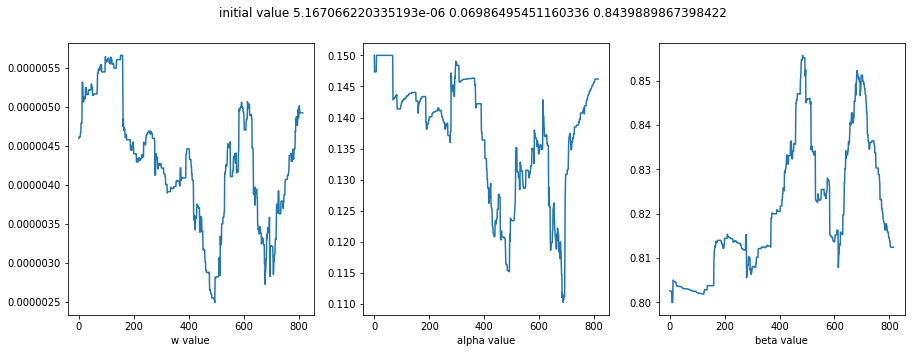

In [173]:
# As an example, take rolling window length to be 700, choose initial value randomly and plot rolling alpha.
import matplotlib.pyplot as plt
import random
for i in range(10):
    random.seed(i)
    w_0, alpha_0 = random.uniform(0.000001,0.00001), random.uniform(0.04,0.12)
    beta_0 = random.uniform(0.9-alpha_0,1-alpha_0)
    b = rolling_alpha_garch(df, 5, 720, [w_0, alpha_0, beta_0], 100)[720+100:]
    w_value = []
    alpha_value = []
    beta_value = []
    for x in b:
        w_value.append(x[0])
        alpha_value.append(x[1])
        beta_value.append(x[2])
    f = plt.figure(figsize=(15,5))
    f.suptitle('initial value '+str(w_0)+' '+str(alpha_0)+' '+str(beta_0))
    ax = f.add_subplot(131)
    ax.set_xlabel('w value')
    ax.plot(w_value)
    ax1 = f.add_subplot(132)
    ax1.set_xlabel('alpha value')
    ax1.plot(alpha_value)
    ax2 = f.add_subplot(133)
    ax2.set_xlabel('beta value')
    ax2.plot(beta_value)
    plt.show()
    plt.close()

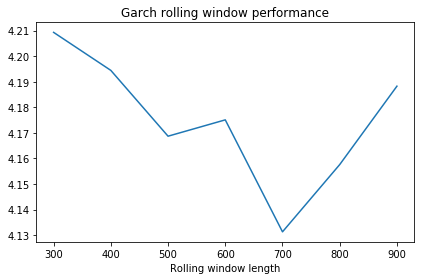

In [181]:
array = np.arange(1, 11)
for i in array:
    random.seed(i+700)
    w_0, alpha_0 = random.uniform(0.000001,0.00001), random.uniform(0.03,0.15)
    beta_0 = random.uniform(0.9-alpha_0,1-alpha_0)
    

[2.7340271858007683e-06, 0.11777562054801669, 0.8556556813411833]
[4.611507078002984e-06, 0.07360542759790867, 0.8999373523103804]
[2.4831603017320526e-06, 0.11812341303930814, 0.8264165966144124]
[1.5769937994016342e-06, 0.18315812083416022, 0.7938156996091239]
[2.5499730776668045e-06, 0.11913848716808445, 0.824325969737695]
[7.616445093720043e-06, 0.020716095558410252, 0.9459108864109185]
[7.2793994598386405e-06, 0.1958816650781207, 0.7151931000477649]
[2.1818854062084057e-06, 0.17815515837672047, 0.7924831838217192]
[6.669088714383822e-06, 0.06877311935989731, 0.8486925016037609]
[5.003397276012738e-06, 0.06836070948650651, 0.9307093785463988]


[7.724259328218038e-06, 0.08992300728252978, 0.8211785088948029]
[7.888295350972403e-06, 0.12515618661778227, 0.7884628071633858]
[1.4511619945092806e-06, 0.048567716608984166, 0.9485923281885889]
[8.568051998344525e-06, 0.07475342784934363, 0.8992659629173975]
[8.020026783160236e-06, 0.030940092171936325, 0.899850542031369]
[6.621539943262139e-06, 0.13612778563456085, 0.790262337481744]
[1.1588090095896855e-06, 0.10592553370861095, 0.8276116764539008]
[2.119668094477901e-06, 0.13126555211142937, 0.8519141235974846]
[5.8074188175574125e-06, 0.062294623601809054, 0.8624728013894789]
[4.425249756667863e-06, 0.09672953496680693, 0.872399254201752]


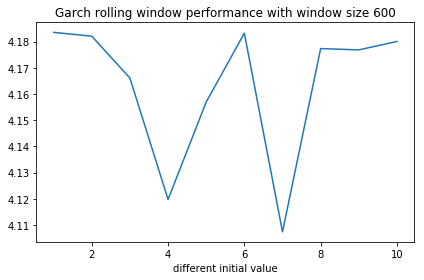

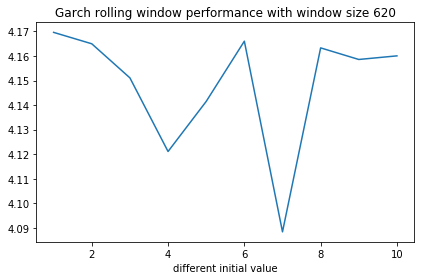

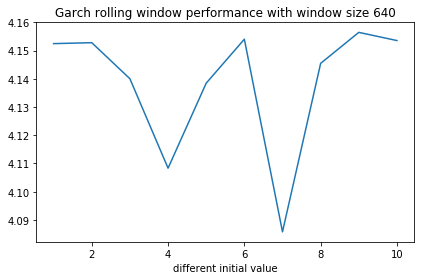

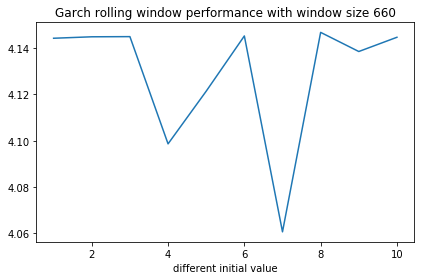

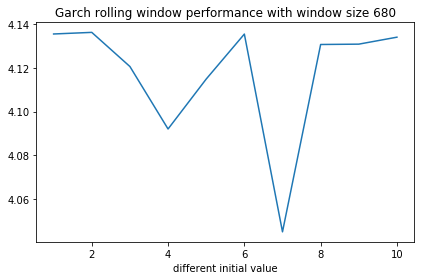

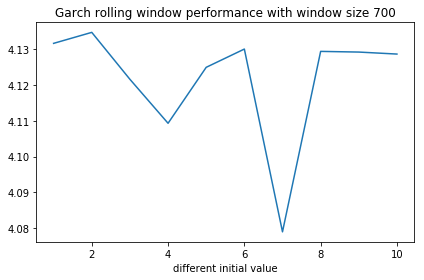

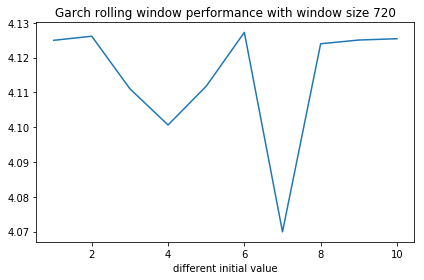

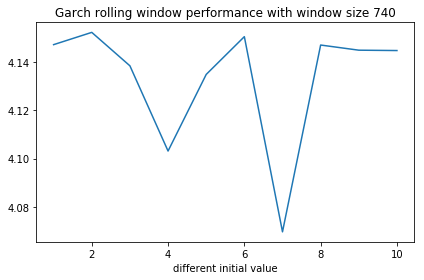

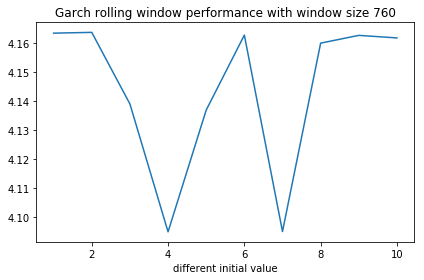

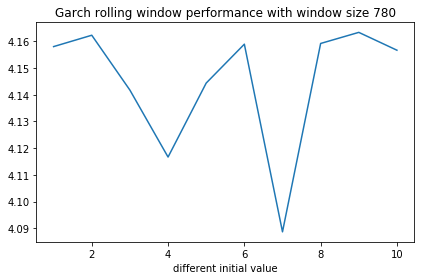

In [20]:
# Choose different initial value and plot the rolling performance for window size 720
import matplotlib.pyplot as plt
import random

initial_value = []
array = np.arange(1, 11)
for i in array:
    random.seed(i+700)
    w_0, alpha_0 = random.uniform(0.000001,0.00001), random.uniform(0.03,0.15)
    beta_0 = random.uniform(0.9-alpha_0,1-alpha_0)
    print([w_0, alpha_0, beta_0])
    initial_value.append([w_0, alpha_0, beta_0])
    
windows = np.arange(600, 800, 20, dtype=int)
for k in windows:
    performance = []
    for i in range(10):
        b = rolling_performance_garch(df, 5, k, initial_value[i], 100)
        performance.append(b)
    plt.plot(array, performance)
    plt.xlabel('different initial value')
    plt.title('Garch rolling window performance with window size '+str(k))
    plt.tight_layout()
    plt.show()
#plt.close()




[7.724259328218038e-06, 0.08992300728252978, 0.8211785088948029]


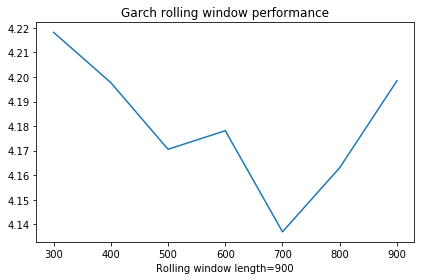

[7.888295350972403e-06, 0.12515618661778227, 0.7884628071633858]


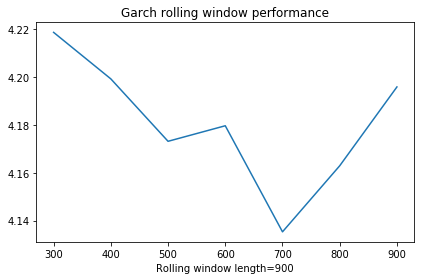

[1.4511619945092806e-06, 0.048567716608984166, 0.9485923281885889]


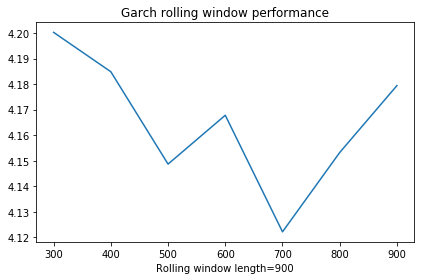

[8.568051998344525e-06, 0.07475342784934363, 0.8992659629173975]


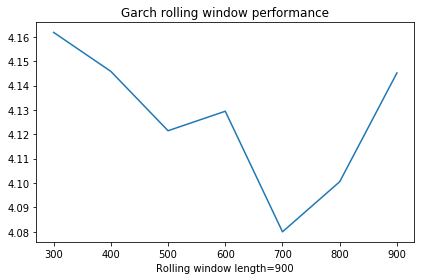

[8.020026783160236e-06, 0.030940092171936325, 0.899850542031369]


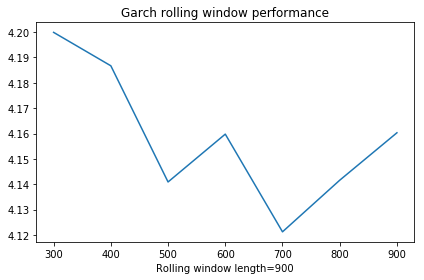

[6.621539943262139e-06, 0.13612778563456085, 0.790262337481744]


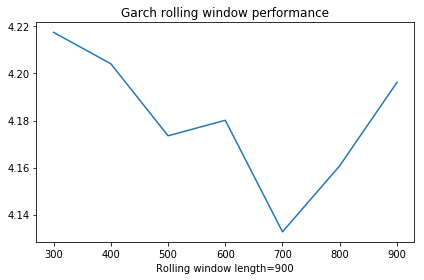

[1.1588090095896855e-06, 0.10592553370861095, 0.8276116764539008]


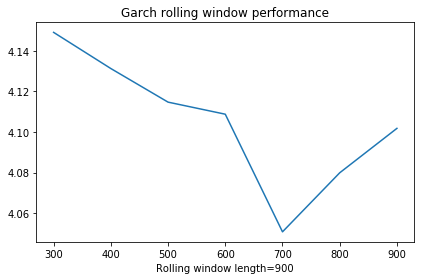

[2.119668094477901e-06, 0.13126555211142937, 0.8519141235974846]


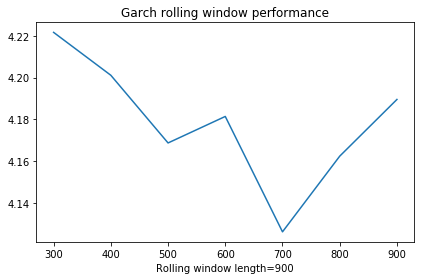

[5.8074188175574125e-06, 0.062294623601809054, 0.8624728013894789]


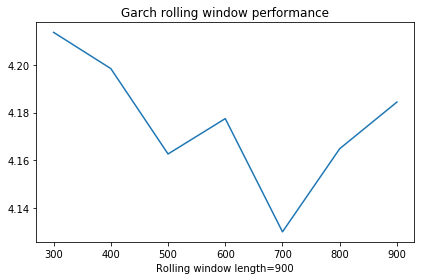

[4.425249756667863e-06, 0.09672953496680693, 0.872399254201752]


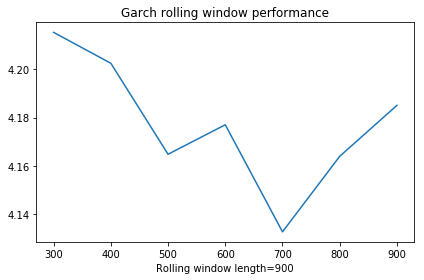

In [29]:
# Choose some initial value and plot the rolling performance for different window size
import matplotlib.pyplot as plt
import random

initial_value = []
array = np.arange(1, 11)
for i in array:
    random.seed(i+700)
    w_0, alpha_0 = random.uniform(0.000001,0.00001), random.uniform(0.03,0.15)
    beta_0 = random.uniform(0.9-alpha_0,1-alpha_0)
    initial_value.append([w_0, alpha_0, beta_0])
    
linespace = np.arange(300, 1000, 100, dtype=int)

for i in range(10):
    print(initial_value[i])
    performance=[]
    for k in linespace:
        b = rolling_performance_garch(df, 5, k, initial_value[i], 100)
        performance.append(b)
    plt.plot(linespace, performance)
    plt.xlabel('Rolling window length')
    plt.title('Garch rolling window performance')
    plt.tight_layout()
    plt.show()
#plt.close()




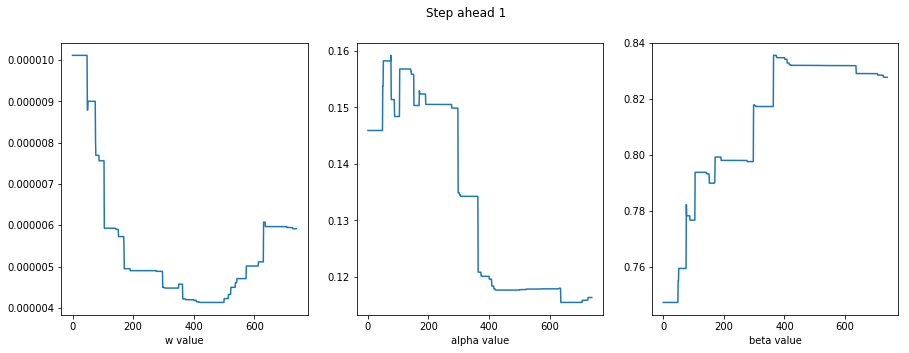

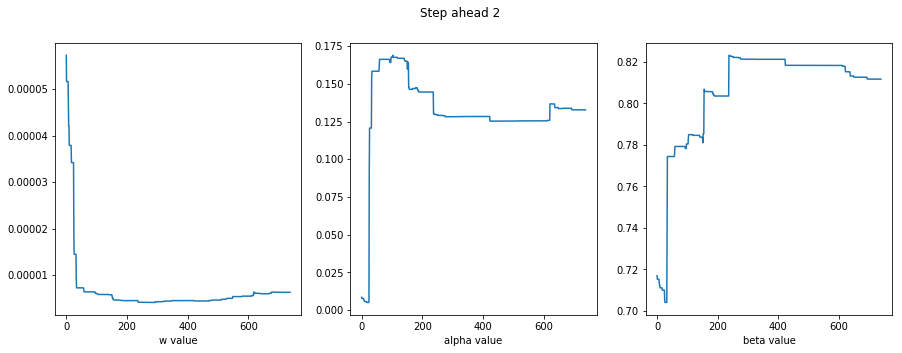

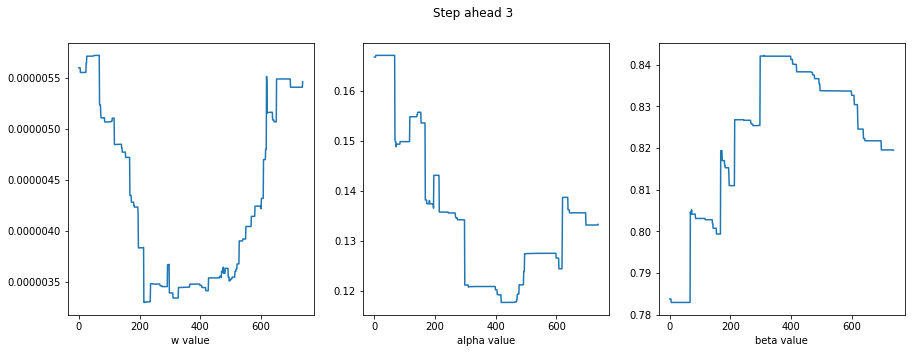

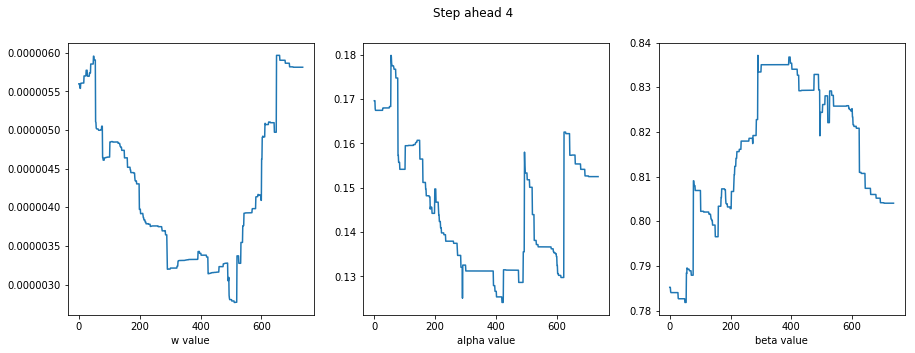

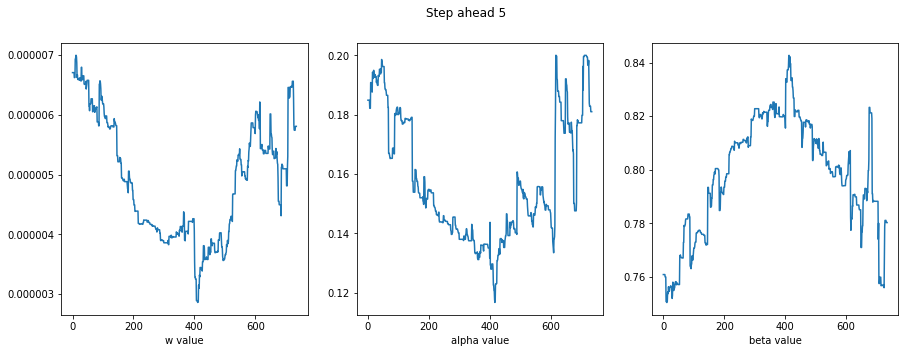

In [52]:
# As an example, take rolling window length to be 720, choose an initial value, drop the window and the
# first 100 samples, compare the plots for different step ahead.

random.seed(10)
w_0, alpha_0 = random.uniform(0.000001,0.00001), random.uniform(0.03,0.15)
beta_0 = random.uniform(0.9-alpha_0,1-alpha_0)
performance = []
x_initial = [w_0, alpha_0, beta_0]

for i in range(1,6):
    b = rolling_alpha_garch(df, i, 720, [w_0, alpha_0, beta_0], 100)[720+100:]
    w_value = []
    alpha_value = []
    beta_value = []
    for x in b:
        w_value.append(x[0])
        alpha_value.append(x[1])
        beta_value.append(x[2])
    f = plt.figure(figsize=(15,5))
    f.suptitle('Step ahead '+str(i))
    ax = f.add_subplot(131)
    ax.set_xlabel('w value')
    ax.plot(w_value)
    ax1 = f.add_subplot(132)
    ax1.set_xlabel('alpha value')
    ax1.plot(alpha_value)
    ax2 = f.add_subplot(133)
    ax2.set_xlabel('beta value')
    ax2.plot(beta_value)
    plt.show()
    plt.close()
    

In [30]:
import math
def expand_hist_garch(returns, step_ahead, window_length, x_initial, dropout):
    estimate_v_garch = expand_v_garch(returns, step_ahead, window_length, x_initial, dropout)
    returns_shift =  returns[step_ahead:] 
    return returns_shift / np.sqrt(estimate_v_garch)






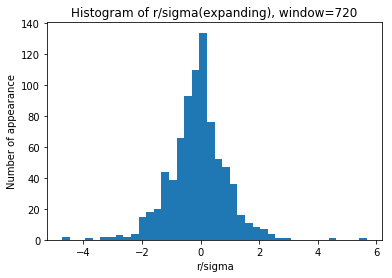

In [31]:
random.seed(2)
w_0, alpha_0 = random.uniform(0.000001,0.00001), random.uniform(0.03,0.15)
beta_0 = random.uniform(0.9-alpha_0,1-alpha_0)
x_initial = [w_0, alpha_0, beta_0]
dropout = 100

plt.hist(expand_hist_garch(df, 5, 720, x_initial, dropout)[720+100:], bins=40)
plt.xlabel('r/sigma')
plt.ylabel('Number of appearance')
plt.title('Histogram of r/sigma(expanding), window=720')
plt.show()

In [32]:
def rolling_hist_garch(returns, step_ahead, window_length, x_initial, dropout):
    estimate_v_garch = rolling_v_garch(returns, step_ahead, window_length, x_initial, dropout)
    returns_shift =  returns[step_ahead:] 
    return returns_shift / np.sqrt(estimate_v_garch)




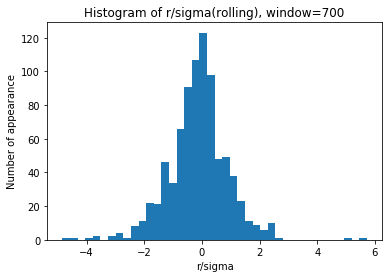

In [35]:
plt.hist(rolling_hist_garch(df, 5, 700, x_initial, dropout)[700+100:], bins=40)
plt.xlabel('r/sigma')
plt.ylabel('Number of appearance')
plt.title('Histogram of r/sigma(rolling), window=700')
plt.show()

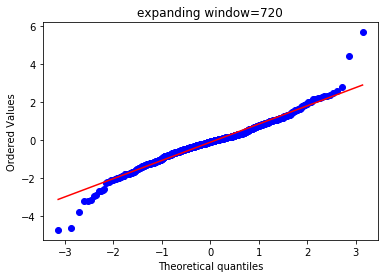

In [34]:
import pylab 
import scipy.stats as stats


stats.probplot(expand_hist_garch(df, 5, 720, x_initial, dropout)[720+100:], dist="norm", plot=pylab)
pylab.title('expanding window=720')
pylab.show()

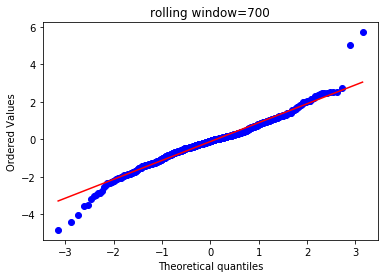

In [36]:
import pylab 
import scipy.stats as stats


stats.probplot(rolling_hist_garch(df, 5, 700, x_initial, dropout)[700+100:], dist="norm", plot
               =pylab)
pylab.title('rolling window=700')
pylab.show()